<a href="https://colab.research.google.com/github/luislucianozurdogmailcom/Analisis-Exploratorio-Terromoto-Nepal/blob/master/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importamos el dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


X_train     = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/train_values.csv',index_col='building_id');
y_train     = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/train_labels.csv',index_col='building_id');
test_values = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/test_values.csv',index_col='building_id');
df          = pd.merge(X_train,y_train,on = 'building_id');

# **Tratamiento de datos con frecuency encoding, subsampleo y normalización**

Eliminamos la columna de ID y encodeamos los datos de variables categoricas a travez de frecuency encoding, las variables de geo_level tambien caerán en este encodeo. Esto es debido a que los numeros dados a las zonas no son representativos de alguna relacion entre los numeros, es decir, fueron dados numeros por poner un numero y poder diferenciarlos mas facilemente.

In [ ]:
df.drop(columns = ['building_id'],inplace = True);

In [ ]:
columnas = ['land_surface_condition',
            'foundation_type',
            'roof_type',
            'ground_floor_type',
            'other_floor_type',
            'position',
            'plan_configuration',
            'legal_ownership_status',
            'geo_level_1_id',
            'geo_level_2_id',
            'geo_level_3_id'];

for row in columnas:
  # Calculamos la frecuencia por cada grado de cada valor de la variable
  Auxiliar = df.groupby([row]).size()/len(df);

  # Reemplazamos la columna por la columna de frecuencias
  df.loc[:,row] = df[row].map(Auxiliar);

Normalizaremos los datos para que las variables esten en un rango de 0 - 1, con su media restada y sobre su desviación estandar

In [ ]:
# Ponemos las variables numericas entre 0-1
df_normalizado = df.copy()
columnas       = ['count_floors_pre_eq',
                  'age',
                  'area_percentage',
                  'height_percentage',
                  'count_families'];

for i in columnas:
  # Restamos la media y lo dividimos por la varianza
  df_normalizado[i] = (df[i]-df[i].mean())/df[i].std();
  
  # Escalamos entre valores entre 0 y 1
  min_value         = df_normalizado[i].min();
  max_value         = df_normalizado[i].max();
  df_normalizado[i] = (df_normalizado[i]-min_value)/(max_value-min_value); 

Debido a que tenemos un set de datos DESBALANCEADO vamos a subsamplear los datos para equilibrar la cantidad de damage_rate para que 1/3 del total sean 1, 1/3 del total sean 2 y el ultimo 1/3 del total sean 3.

In [ ]:
# Agrupamos por valor de damage_grade y contamos sus repeticiones en el dataset
sub_sampleo_count = df_normalizado.groupby(['damage_grade']).agg({'roof_type':'count'});

# Buscamos el valor de damage_grade que presenta menor numero de repeticiones
sub_sampleo_min   = sub_sampleo_count['roof_type'].min()

# Separamos el dataframe en tres df con los valores de damage_grade en 1,2 y 3
df_normalizado_damage_1 = df_normalizado[df_normalizado['damage_grade'] == 1];
df_normalizado_damage_2 = df_normalizado[df_normalizado['damage_grade'] == 2];
df_normalizado_damage_3 = df_normalizado[df_normalizado['damage_grade'] == 3];

# Desordenamos los datos aleatoriamente de los tres dataframes
df_normalizado_damage_1 = df_normalizado_damage_1.sample(frac=1)
df_normalizado_damage_2 = df_normalizado_damage_2.sample(frac=1)
df_normalizado_damage_3 = df_normalizado_damage_3.sample(frac=1)

# Sub sampleamos
df_normalizado_damage_1 = df_normalizado_damage_1.iloc[0:sub_sampleo_min];
df_normalizado_damage_2 = df_normalizado_damage_2.iloc[0:sub_sampleo_min];
df_normalizado_damage_3 = df_normalizado_damage_3.iloc[0:sub_sampleo_min];

# Unimos los df nuevamente en un unico df ya subsampleado y lo desordenamos nuevamente
df_normalizado_subsampleado = pd.concat([df_normalizado_damage_1,df_normalizado_damage_2,df_normalizado_damage_3],axis=0);
df_normalizado_subsampleado = df_normalizado_subsampleado.sample(frac=1);

El df_normalizado_subsampleado será el dataframe con las condiciones ideoneas para encajar en varias distribuciones o soluciones, ya que será un dataframe balanceado en cuanto a labels, estará encodeado y normalizado con lo cual todos los features serán valores entre 0 y 1.

# **Tratamiento de datos con mean encoding y normalización + feature volumen**

Creamos tres columnas que reemplazarán a el label, serán damage_grade_1, damage_grade_2 y damage_grade_3

In [ ]:
df_mean   = df.copy();
test_mean = test_values.copy();

# Creamos las tres columnas nuevas para los damage
df_mean['damage_grade_1'] = [1 if s == 1 else 0 for s in df['damage_grade']]
df_mean['damage_grade_2'] = [1 if s == 2 else 0 for s in df['damage_grade']]
df_mean['damage_grade_3'] = [1 if s == 3 else 0 for s in df['damage_grade']]
#df_mean.drop(columns=['damage_grade'],inplace=True);

Encodeamos las columnas de variables categoricas

In [ ]:
columnas = ['land_surface_condition',
            'geo_level_3_id',
            'roof_type',
            'ground_floor_type',
            'other_floor_type',
            'position',
            'plan_configuration',
            'legal_ownership_status',
            'geo_level_1_id',
            'geo_level_2_id',
            'foundation_type'];

for row in columnas:
  Auxiliar_1 = row + '_1'
  Auxiliar_2 = row + '_2'
  Auxiliar_3 = row + '_3'
  
  # Calculamos la frecuencia por cada grado de cada valor de la variable damage_grade
  Auxiliar_mean_1 = df_mean.groupby([row])['damage_grade_1'].mean()
  Auxiliar_mean_2 = df_mean.groupby([row])['damage_grade_2'].mean()
  Auxiliar_mean_3 = df_mean.groupby([row])['damage_grade_3'].mean()

  # Llenamos las columnas con las frecuencias 
  df_mean.loc[:,Auxiliar_1]   = df_mean[row].map(Auxiliar_mean_1);
  df_mean.loc[:,Auxiliar_2]   = df_mean[row].map(Auxiliar_mean_2);
  df_mean.loc[:,Auxiliar_3]   = df_mean[row].map(Auxiliar_mean_3);
  test_mean.loc[:,Auxiliar_1] = test_mean[row].map(Auxiliar_mean_1);
  test_mean.loc[:,Auxiliar_2] = test_mean[row].map(Auxiliar_mean_2);
  test_mean.loc[:,Auxiliar_3] = test_mean[row].map(Auxiliar_mean_3);

Borramos las columnas que encodeamos para dejar solo las nuevas fabricadas

In [ ]:
columnas = ['land_surface_condition',
            'geo_level_3_id',
            'roof_type',
            'ground_floor_type',
            'other_floor_type',
            'position',
            'plan_configuration',
            'legal_ownership_status',
            'geo_level_1_id',
            'geo_level_2_id',
            'foundation_type'];
df_mean.drop(columns = columnas,axis=1,inplace=True);
test_mean.drop(columns = columnas,axis=1,inplace=True);

Creamos una nueva columna numérica para el volumen de la estructura, esta estará definida como Area * Altura del edificio.

In [ ]:
df_mean['volumen_normalizado']        = df_mean['area_percentage']*df_mean['height_percentage'];
test_mean['volumen_normalizado']      = test_mean['area_percentage']*test_mean['height_percentage'];

df_normalizado_mean   = df_mean.copy();
test_normalizado_mean = test_mean.copy();
#df_mean['alargamiento_normalizado'] = df_mean['height_percentage']/df_mean['area_percentage'];

In [ ]:
df_normalizado_mean

Normalizamos las variables numéricas

In [ ]:
# ........................................Celda de normalización...............................
# Ponemos las variables numericas entre 0-1
df_normalizado_mean = df_mean.copy()
columnas            = ['count_floors_pre_eq',
                  'age',
                  'area_percentage',
                  'height_percentage',
                  'count_families',
                  'volumen_normalizado'];

for i in columnas:
  # Restamos la media y lo dividimos por la varianza
  df_normalizado_mean[i] = (df_mean[i]-df_mean[i].mean())/df_mean[i].std();
  
  # Escalamos entre valores entre 0 y 1
  min_value         = df_normalizado_mean[i].min();
  max_value         = df_normalizado_mean[i].max();
  df_normalizado_mean[i] = (df_normalizado_mean[i]-min_value)/(max_value-min_value); 

Borramos las columnas de damage_grade_1, ..._2, ..._3

In [ ]:
df_normalizado_mean.drop(columns=['damage_grade_1'],inplace=True);
df_normalizado_mean.drop(columns=['damage_grade_2'],inplace=True);
df_normalizado_mean.drop(columns=['damage_grade_3'],inplace=True);

Guardamos el CSV

In [ ]:
df_normalizado_mean.to_csv('/content/gdrive/MyDrive/Colab Notebooks/dataset_meanEncoding_normalizado.csv');

# **Features Importance**

Ahora vamos a buscar los features importances a traves del metodo de Random Forest

In [ ]:
# from sklearn.decomposition import PCA
from sklearn import neighbors, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Separamos el dataframe en test y train
df_normalizado_subsampleado_X = df_normalizado_subsampleado.drop(columns=['damage_grade']);
df_normalizado_subsampleado_y = df_normalizado_subsampleado['damage_grade'];

X_train, X_test, y_train, y_test = train_test_split(df_normalizado_subsampleado_X,df_normalizado_subsampleado_y,test_size = 0.2, random_state = 42);
y_train                          = y_train.to_numpy();
y_test                           = y_test.to_numpy();

Extraemos los nombres de las columnas e instanciamos el modelo y lo entramos

In [ ]:
feature_names = df_normalizado_subsampleado_X.columns.values
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

Graficamos la importancia de los features

In [ ]:
plt.figure(dpi=100)
plt.bar(feature_names,forest.feature_importances_)
plt.xlabel('Features en el dataset')
plt.ylabel('Importancia')
plt.xticks(rotation = 90)

# **Feature importance para mean encoding**

In [ ]:
# from sklearn.decomposition import PCA
from sklearn import neighbors, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Separamos el dataframe en test y train
df_normalizado_mean_X = df_normalizado_mean.drop(columns=['damage_grade']);
df_normalizado_mean_y = df_normalizado_mean['damage_grade'];
#df_normalizado_mean_y = df_normalizado_mean[['damage_grade_1','damage_grade_2','damage_grade_3']];

X_train, X_test, y_train, y_test = train_test_split(df_normalizado_mean_X,df_normalizado_mean_y,test_size = 0.1, random_state = 41);
#y_train                          = y_train.to_numpy();
#y_test                           = y_test.to_numpy();

Extraemos los nombres de las columnas e instanciamos el modelo y lo entramos

In [ ]:
feature_names = df_normalizado_mean_X.columns.values
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
diccionario = pd.DataFrame(list(zip(feature_names,forest.feature_importances_*100)), columns = ['features','importance (%)']);

Graficamos la importancia de los features

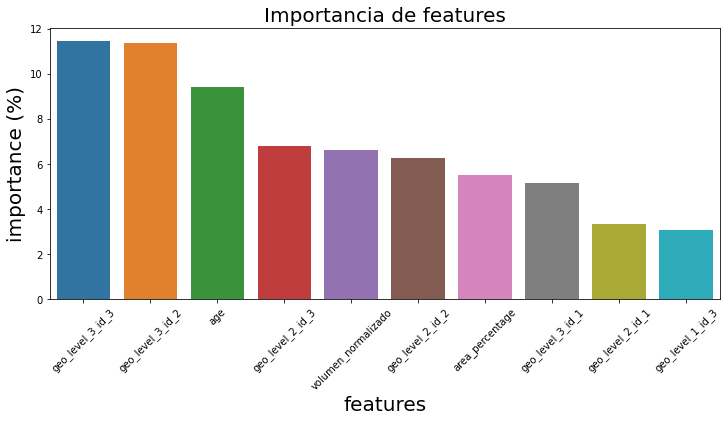

In [ ]:
primeros = diccionario.nlargest(10,columns=['importance (%)']);

plt.figure(figsize=(12,5))
sns.barplot(x = "features", y = "importance (%)",data = primeros)
plt.xticks(rotation = 45,fontsize = 10)
plt.yticks(fontsize = 10)
plt.title('Importancia de features', fontsize=20)
plt.xlabel('features', fontsize=20)
plt.ylabel('importance (%)', fontsize=20)
plt.show()

# **Modelos**

Linea de importación

In [ ]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,make_scorer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

Separamos el dataset con el train test split

In [ ]:
# Separamos el dataframe en test y train
df_normalizado_mean_X = df_normalizado_mean.drop(columns=['damage_grade']);
df_normalizado_mean_y = df_normalizado_mean['damage_grade'];
test_normalizado_mean;
#df_normalizado_mean_y = df_normalizado_mean[['damage_grade_1','damage_grade_2','damage_grade_3']];

X_train, X_test, y_train, y_test = train_test_split(df_normalizado_mean_X,df_normalizado_mean_y,test_size = 0.2);
#y_train                          = y_train.to_numpy();
#y_test                           = y_test.to_numpy();

instalamos el modelo

In [ ]:
!pip install catboost

     |████████████████████████████████| 69.2 MB 5.1 kB/s 


Importamos el modelo y lo instanciamos

In [ ]:
from catboost import CatBoostClassifier

CBC = CatBoostClassifier(random_state=2018);

Creamos el parametro de grillado

In [ ]:
param_grid = {"learning_rate"    : [0.04,0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
              "max_depth"        : [10, 12, 15, 30, 50],
              "iterations"       : [100, 150, 200, 250, 300]}

Instanciamos el F1 score

In [ ]:
f1 = make_scorer(f1_score , average='micro');

Instanciamos el RandomSearch

In [ ]:
rs = RandomizedSearchCV(CBC, param_grid, cv=3, scoring=f1);

Entreno el modelo

In [ ]:
#CBC.fit(X_train, y_train.values);
CBC.fit(X_train, y_train.values.ravel());

Learning rate set to 0.103895
0:	learn: 1.0090159	total: 330ms	remaining: 5m 29s
1:	learn: 0.9397756	total: 551ms	remaining: 4m 34s
2:	learn: 0.8835563	total: 772ms	remaining: 4m 16s
3:	learn: 0.8373759	total: 990ms	remaining: 4m 6s
4:	learn: 0.7991401	total: 1.2s	remaining: 3m 58s
5:	learn: 0.7672230	total: 1.42s	remaining: 3m 55s
6:	learn: 0.7398871	total: 1.64s	remaining: 3m 52s
7:	learn: 0.7170058	total: 1.85s	remaining: 3m 49s
8:	learn: 0.6966166	total: 2.08s	remaining: 3m 48s
9:	learn: 0.6788230	total: 2.3s	remaining: 3m 47s
10:	learn: 0.6638125	total: 2.53s	remaining: 3m 47s
11:	learn: 0.6505314	total: 2.73s	remaining: 3m 45s
12:	learn: 0.6388002	total: 2.94s	remaining: 3m 43s
13:	learn: 0.6282105	total: 3.17s	remaining: 3m 43s
14:	learn: 0.6187631	total: 3.37s	remaining: 3m 41s
15:	learn: 0.6114947	total: 3.6s	remaining: 3m 41s
16:	learn: 0.6041281	total: 3.82s	remaining: 3m 41s
17:	learn: 0.5973056	total: 4.06s	remaining: 3m 41s
18:	learn: 0.5918456	total: 4.31s	remaining: 3m 

Miramos los mejores estimadores del modelo

In [ ]:
#returns the estimator with the best performance
print('El mejor estimador es: ',rs.best_estimator_)

#returns the best score
print('El mejor score es: ',rs.best_score_)

#returns the best parameters
print('Los mejores parámetros son: ',rs.best_params_)

Medimos la performance del modelo con X_train con la metrica F1

In [ ]:
#in_sample_preds = CBC.predict(X_train)
#f1_score(y_train, in_sample_preds, average='micro')
in_sample_preds = CBC.predict(X_train)
f1_score(y_train, in_sample_preds, average='micro')

0.7785495011511896

Medimos la performance del modelo con X_test con la metrica F1

In [ ]:
#in_sample_preds = CBC.predict(X_test)
#f1_score(y_test, in_sample_preds, average='micro')
in_sample_preds = CBC.predict(X_test)
f1_score(y_test, in_sample_preds, average='micro')

0.7616507741601274

Transformar columnas de test_values

In [ ]:
predictions = CBC.predict(test_normalizado_mean)

Guardamos las predicciones

In [ ]:
submission_format = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/submission_format.csv', index_col='building_id')

In [ ]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission.head()

In [ ]:
my_submission.to_csv('/content/gdrive/MyDrive/Colab Notebooks/submission9.csv')

In [ ]:
!head submission.csv

head: cannot open 'submission.csv' for reading: No such file or directory


In [ ]:
my_submission.damage_grade.value_counts()